In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, f1_score

from tqdm import tqdm
from math import log10

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, mean_squared_error
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from sklearn.metrics import top_k_accuracy_score
from sklearn.feature_selection import f_classif, f_regression

## Get top 10 features for SDP network + SCIP running time prediction

In [5]:
runtimes = pd.read_excel('C:/Users/Jasmin/Documents/MSc-Thesis/Data/Runtime/Results-MIPVerify_SDPdMLPa.xlsx')
df = pd.read_csv('C:/Users/Jasmin/Documents/MSc-Thesis/Feature_Extraction/feature_data_rp/RP_data_07.csv')
df['INSTANCE_NAME'] = df['INSTANCE_NAME'].astype('str').str.extractall('(\d+)').unstack().fillna('').sum(axis=1).astype(int)
lp_list = list(df['INSTANCE_NAME'])
runtimes = runtimes.loc[runtimes['SampleNumber'].isin(lp_list)]
df = df.rename(columns={"INSTANCE_NAME": "SampleNumber"})
## Join the two datasets by samplenumber/lp_file
df = pd.merge(df, runtimes, on="SampleNumber")
nunique = df.nunique()
cols_to_drop = nunique[nunique == 1].index
df = df.drop(cols_to_drop, axis=1)
df = df.T.drop_duplicates().T
df

,n_vars,n_constr,n_nzcnt,lp_avg,lp_l2_avg,lp_linf,num_i_variables,num_c_variables,ratio_i_variables,ratio_c_variables,...,SolveTime_default,SolveStatus_default,SolveTime_conf1,SolveStatus_conf1,SolveTime_conf2,SolveStatus_conf2,SolveTime_conf3,SolveStatus_conf3,SolveTime_best,Config_best
0,3005.0,4440.0,532558.0,0.110512,0.191534,0.49789,330.0,2675.0,0.109817,0.890183,...,104.393417,InfeasibleOrUnbounded,152.683291,InfeasibleOrUnbounded,44.068493,Infeasible,78.731996,Infeasible,44.068493,SolveTime_conf2
1,2971.0,4372.0,505477.0,0.134393,0.221089,0.49955,313.0,2658.0,0.105352,0.894648,...,9600.019248,UserLimit,9600.330209,UserLimit,9600.206703,UserLimit,9600.171495,UserLimit,9600.019248,TIMEOUT
2,2967.0,4364.0,502291.0,0.106764,0.190398,0.498555,311.0,2656.0,0.10482,0.89518,...,89.865928,InfeasibleOrUnbounded,779.582903,InfeasibleOrUnbounded,80.580781,Infeasible,215.399513,Infeasible,80.580781,SolveTime_conf2
3,3011.0,4452.0,537337.0,0.230292,0.322005,0.499855,333.0,2678.0,0.110594,0.889406,...,9600.048013,UserLimit,9600.379411,UserLimit,9600.130473,UserLimit,9600.117678,UserLimit,9600.048013,TIMEOUT
4,2897.0,4224.0,446536.0,0.13335,0.217471,0.498412,276.0,2621.0,0.095271,0.904729,...,22.112561,InfeasibleOrUnbounded,378.362607,InfeasibleOrUnbounded,78.919991,Infeasible,18.838446,Infeasible,18.838446,SolveTime_conf3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2943.0,4316.0,483175.0,0.125741,0.204121,0.499159,299.0,2644.0,0.101597,0.898403,...,136.404467,InfeasibleOrUnbounded,169.627541,InfeasibleOrUnbounded,179.118139,Infeasible,200.96392,Infeasible,136.404467,SolveTime_default
9996,2843.0,4116.0,403525.0,0.129329,0.21971,0.499019,249.0,2594.0,0.087583,0.912416,...,12.67472,InfeasibleOrUnbounded,18608.097787,UserLimit,25.863838,Infeasible,172.11687,Infeasible,12.67472,SolveTime_default
9997,2947.0,4324.0,486361.0,0.161295,0.257694,0.499142,301.0,2646.0,0.102138,0.897862,...,18.37995,InfeasibleOrUnbounded,110.131027,InfeasibleOrUnbounded,50.209194,Infeasible,110.876559,Infeasible,18.37995,SolveTime_default
9998,2933.0,4296.0,475210.0,0.125582,0.210217,0.49904,294.0,2639.0,0.100239,0.899761,...,75.684641,InfeasibleOrUnbounded,105.670172,InfeasibleOrUnbounded,106.346014,Infeasible,102.81169,Infeasible,75.684641,SolveTime_default


In [6]:
df['SolveTime_default'][df['SolveTime_default'] >= 9600] = 9600
df['SolveTime_conf1'][df['SolveTime_conf1'] >= 9600] = 9600
df['SolveTime_conf2'][df['SolveTime_conf2'] >= 9600] = 9600
df['SolveTime_conf3'][df['SolveTime_conf3'] >= 9600] = 9600
df['SolveTime_best'][df['SolveTime_best'] >= 9600] = 9600
df.head()

,n_vars,n_constr,n_nzcnt,lp_avg,lp_l2_avg,lp_linf,num_i_variables,num_c_variables,ratio_i_variables,ratio_c_variables,...,SolveTime_default,SolveStatus_default,SolveTime_conf1,SolveStatus_conf1,SolveTime_conf2,SolveStatus_conf2,SolveTime_conf3,SolveStatus_conf3,SolveTime_best,Config_best
0,3005.0,4440.0,532558.0,0.110512,0.191534,0.49789,330.0,2675.0,0.109817,0.890183,...,104.393417,InfeasibleOrUnbounded,152.683291,InfeasibleOrUnbounded,44.068493,Infeasible,78.731996,Infeasible,44.068493,SolveTime_conf2
1,2971.0,4372.0,505477.0,0.134393,0.221089,0.49955,313.0,2658.0,0.105352,0.894648,...,9600,UserLimit,9600,UserLimit,9600,UserLimit,9600,UserLimit,9600,TIMEOUT
2,2967.0,4364.0,502291.0,0.106764,0.190398,0.498555,311.0,2656.0,0.10482,0.89518,...,89.865928,InfeasibleOrUnbounded,779.582903,InfeasibleOrUnbounded,80.580781,Infeasible,215.399513,Infeasible,80.580781,SolveTime_conf2
3,3011.0,4452.0,537337.0,0.230292,0.322005,0.499855,333.0,2678.0,0.110594,0.889406,...,9600,UserLimit,9600,UserLimit,9600,UserLimit,9600,UserLimit,9600,TIMEOUT
4,2897.0,4224.0,446536.0,0.13335,0.217471,0.498412,276.0,2621.0,0.095271,0.904729,...,22.112561,InfeasibleOrUnbounded,378.362607,InfeasibleOrUnbounded,78.919991,Infeasible,18.838446,Infeasible,18.838446,SolveTime_conf3


In [7]:
dumb_array = df['SolveTime_default'].to_numpy()
#np.log(dumb_array)
new_list = []
for elem in tqdm(dumb_array):
    new_list.append(log10(elem))

100%|██████████| 10000/10000 [00:00<00:00, 789456.61it/s]


In [8]:
X = df.drop(['SolveTime_default','SampleNumber', 'SolveStatus_default', 'SolveTime_conf1', 'SolveStatus_conf1','SolveTime_conf2', 'SolveStatus_conf2', 'SolveTime_conf3', 'SolveStatus_conf3', 'SolveTime_best', 'Config_best'], axis = 1)
y = new_list


training, testing, training_labels, testing_labels = train_test_split(X, y, test_size = .5)


rf=RandomForestRegressor()
rf.fit(training, training_labels)

preds = rf.predict(testing)
mse = mean_squared_error(testing_labels, preds)
rmse = mse**.5
print("mse:", mse)
print("rmse:", rmse)


pd.DataFrame(rf.feature_importances_, index=training.columns).sort_values(by=0, ascending=False).head(10).T

mse: 0.8523704715710186
rmse: 0.9232391193894562


,rhs_c_1_avg,rhs_c_0_avg,mipgap,lp_l2_avg,rhs_c_1_varcoef,vcg_var_weight1_avg,rhs_c_2_avg,vcg_var_weight1_varcoef,rhs_c_0_varcoef,cplex_prob_time
0,0.099091,0.052352,0.049904,0.047015,0.040674,0.039505,0.036375,0.034361,0.031792,0.028907


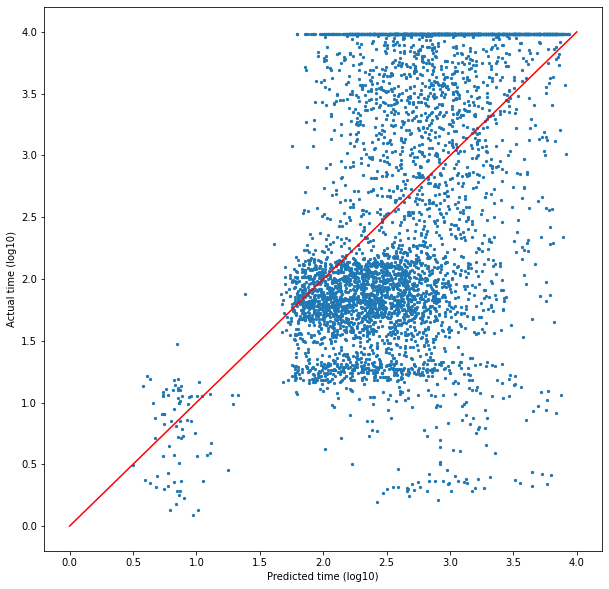

In [9]:
plt.subplots(figsize=(10, 10))
plt.scatter(x=preds, y=testing_labels, s=5)
plt.plot([0,1,2,3,4], color='red') 
plt.xlabel('Predicted time (log10)') 
plt.ylabel('Actual time (log10)')
#plt.title('Running time predictions for Config default with all SCIP features (rmse = ' + str(round(rmse,4)) + ')')
plt.show()

## PCA for running time prediction SCIP features

In [10]:
# import all libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [11]:
X = df.drop(['SolveTime_default','SampleNumber', 'SolveStatus_default', 'SolveTime_conf1', 'SolveStatus_conf1','SolveTime_conf2', 'SolveStatus_conf2', 'SolveTime_conf3', 'SolveStatus_conf3', 'SolveTime_best', 'Config_best'], axis = 1)
y = df['SolveTime_default']

x_scaled = StandardScaler().fit_transform(X)

pca = PCA(n_components=2)
pcs = pca.fit_transform(x_scaled)


pcaDF = pd.DataFrame(data = pcs, columns = ['principal component 1', 'principal component 2'])
print(pcaDF)

print(pca.components_)

# ratio of the total variance each principal component captures.
print(sum(pca.explained_variance_ratio_))

dfpca = pd.concat([pcaDF, y], axis = 1)
dfpca

      principal component 1  principal component 2
0                  5.805914               2.010109
1                  1.647335               0.936861
2                  1.037994              -4.662641
3                  7.512266               0.505471
4                 -8.226842              -1.839786
...                     ...                    ...
9995              -2.451278               6.016325
9996             -16.988418               1.086691
9997              -2.049178              -2.188378
9998              -3.838410              -1.382111
9999              -2.369766               4.704768

[10000 rows x 2 columns]
[[ 1.46403312e-01  1.46403312e-01  1.46403312e-01 -2.36667390e-03
  -5.69521632e-03  8.11733698e-04  1.46403312e-01  1.46403312e-01
   1.46440881e-01 -1.46440880e-01 -1.16310231e-02  7.51073412e-02
  -1.01173428e-01  9.23537266e-02  1.81953392e-02  1.96872559e-03
   1.46433985e-01 -1.46023733e-01  8.67130459e-03  2.09444984e-02
  -3.99023506e-02  4.34129166e-0

,principal component 1,principal component 2,SolveTime_default
0,5.805914,2.010109,104.393417
1,1.647335,0.936861,9600
2,1.037994,-4.662641,89.865928
3,7.512266,0.505471,9600
4,-8.226842,-1.839786,22.112561
...,...,...,...
9995,-2.451278,6.016325,136.404467
9996,-16.988418,1.086691,12.67472
9997,-2.049178,-2.188378,18.37995
9998,-3.838410,-1.382111,75.684641


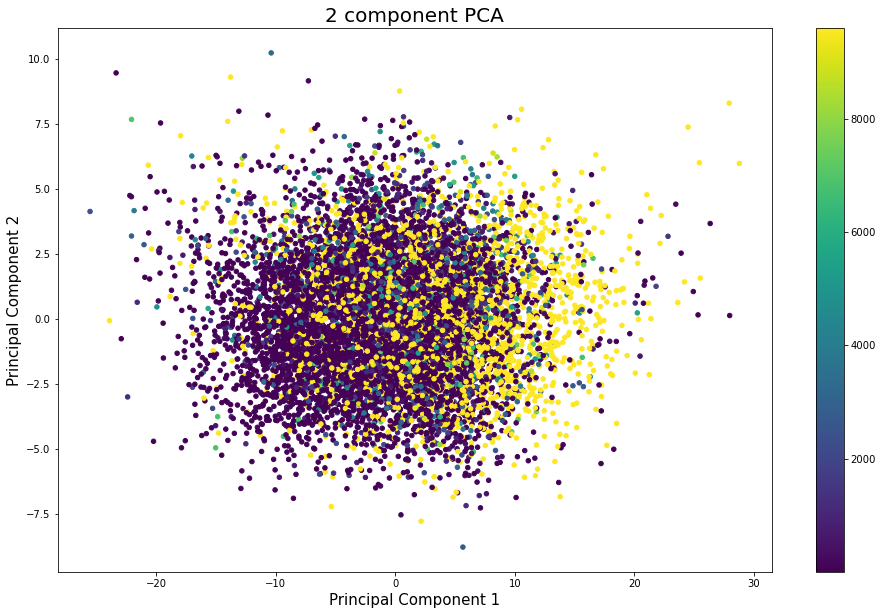

In [33]:
fig = plt.figure(figsize = (16,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)



im = ax.scatter(dfpca['principal component 1'], 
           dfpca['principal component 2'],
             c = dfpca['SolveTime_default'], s = 20)


fig.colorbar(im, ax=ax)

plt.show()

In [39]:
X = df.drop(['SolveTime_default','SampleNumber', 'SolveStatus_default', 'SolveTime_conf1', 'SolveStatus_conf1','SolveTime_conf2', 'SolveStatus_conf2', 'SolveTime_conf3', 'SolveStatus_conf3', 'SolveTime_best', 'Config_best'], axis = 1)
y = df['SolveTime_default']
x_scaled = StandardScaler().fit_transform(X)

EVR = []
nlist = []
for n in range(40):
    pca = PCA(n_components=n)
    pca.fit_transform(x_scaled)
    # ratio of the total variance each principal component captures.
    print(sum(pca.explained_variance_ratio_))
    EVR.append(sum(pca.explained_variance_ratio_))
    nlist.append(n)
    

0
0.5738184542407843
0.647668621502714
0.6954016194237695
0.7269493528619648
0.7567385665658656
0.784064940586817
0.8068622678956926
0.8225076487253791
0.8373898659471566
0.8513369216897543
0.8640125154134453
0.8765873046029098
0.888940676493778
0.9012162985254407
0.9132526680139584
0.9249237284106447
0.9361389658194469
0.946571250049069
0.9552824049899128
0.9635134935457169
0.9706350578771294
0.9769925637826349
0.9825824627815145
0.9868114349920178
0.9902382657598409
0.9927341045151769
0.9949653902234207
0.996322296473694
0.9975772072271051
0.9982930491456743
0.9989457244094307
0.9993686908352322
0.999652293470067
0.9998690799832639
0.9999165646077935
0.999959007583736
0.9999833605162122
0.9999902189329191
0.9999945117854306


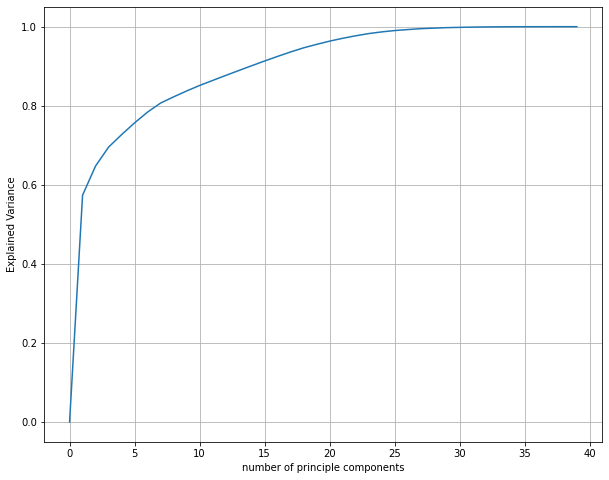

In [40]:
plt.figure(figsize=(10,8))
plt.plot(nlist, EVR)
plt.xticks(np.arange(0, 41, step=5))
plt.xlabel('number of principle components')
plt.ylabel('Explained Variance')
plt.grid()
plt.show()

## Get top features for other configs

In [41]:
dumb_array = df['SolveTime_conf1'].to_numpy()
#np.log(dumb_array)
new_list = []
for elem in tqdm(dumb_array):
    new_list.append(log10(elem))


X = df.drop(['SolveTime_default','SampleNumber', 'SolveStatus_default', 'SolveTime_conf1', 'SolveStatus_conf1','SolveTime_conf2', 'SolveStatus_conf2', 'SolveTime_conf3', 'SolveStatus_conf3', 'SolveTime_best', 'Config_best'], axis = 1)
y = new_list


training, testing, training_labels, testing_labels = train_test_split(X, y, test_size = .5)


rf=RandomForestRegressor()
rf.fit(training, training_labels)

preds = rf.predict(testing)
mse = mean_squared_error(testing_labels, preds)
rmse = mse**.5
print("mse:", mse)
print("rmse:", rmse)


pd.DataFrame(rf.feature_importances_, index=training.columns).sort_values(by=0, ascending=False).head(10).T

100%|██████████| 10000/10000 [00:00<00:00, 824109.24it/s]

mse: 0.48665153024446556
rmse: 0.6976041357707575


,vcg_var_weight1_varcoef,rhs_c_1_avg,vcg_var_weight1_avg,rhs_c_0_avg,lp_l2_avg,rhs_c_0_varcoef,rhs_c_2_avg,clique_table,rhs_c_1_varcoef,cplex_prob_time
0,0.088273,0.063759,0.059032,0.043089,0.041948,0.03088,0.030133,0.029962,0.028738,0.028529


In [42]:
dumb_array = df['SolveTime_conf2'].to_numpy()
#np.log(dumb_array)
new_list = []
for elem in tqdm(dumb_array):
    new_list.append(log10(elem))


X = df.drop(['SolveTime_default','SampleNumber', 'SolveStatus_default', 'SolveTime_conf1', 'SolveStatus_conf1','SolveTime_conf2', 'SolveStatus_conf2', 'SolveTime_conf3', 'SolveStatus_conf3', 'SolveTime_best', 'Config_best'], axis = 1)
y = new_list


training, testing, training_labels, testing_labels = train_test_split(X, y, test_size = .5)


rf=RandomForestRegressor()
rf.fit(training, training_labels)

preds = rf.predict(testing)
mse = mean_squared_error(testing_labels, preds)
rmse = mse**.5
print("mse:", mse)
print("rmse:", rmse)


pd.DataFrame(rf.feature_importances_, index=training.columns).sort_values(by=0, ascending=False).head(10).T

100%|██████████| 10000/10000 [00:00<00:00, 3353565.20it/s]

mse: 0.7484266969306654
rmse: 0.8651165799651891


,mipgap,rhs_c_1_avg,vcg_var_weight1_varcoef,vcg_var_weight1_avg,rhs_c_0_avg,lp_l2_avg,rhs_c_0_varcoef,rhs_c_1_varcoef,rhs_c_2_avg,vcg_constr_weight2_varcoef
0,0.081931,0.06458,0.063933,0.058728,0.038619,0.038532,0.035684,0.035175,0.032469,0.027711


In [43]:
dumb_array = df['SolveTime_conf3'].to_numpy()
#np.log(dumb_array)
new_list = []
for elem in tqdm(dumb_array):
    new_list.append(log10(elem))


X = df.drop(['SolveTime_default','SampleNumber', 'SolveStatus_default', 'SolveTime_conf1', 'SolveStatus_conf1','SolveTime_conf2', 'SolveStatus_conf2', 'SolveTime_conf3', 'SolveStatus_conf3', 'SolveTime_best', 'Config_best'], axis = 1)
y = new_list


training, testing, training_labels, testing_labels = train_test_split(X, y, test_size = .5)


rf=RandomForestRegressor()
rf.fit(training, training_labels)

preds = rf.predict(testing)
mse = mean_squared_error(testing_labels, preds)
rmse = mse**.5
print("mse:", mse)
print("rmse:", rmse)


pd.DataFrame(rf.feature_importances_, index=training.columns).sort_values(by=0, ascending=False).head(10).T

100%|██████████| 10000/10000 [00:00<00:00, 885546.83it/s]

mse: 0.7674129316092961
rmse: 0.8760210794320512


,mipgap,rhs_c_1_avg,vcg_var_weight1_varcoef,rhs_c_0_avg,vcg_var_weight1_avg,rhs_c_0_varcoef,lp_l2_avg,clique_table,rhs_c_1_varcoef,rhs_c_2_avg
0,0.073655,0.070641,0.058006,0.040624,0.040172,0.038561,0.035733,0.03333,0.030482,0.030394
